In [1]:
from __future__ import unicode_literals,print_function,division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
SOS_token = 0
EOS_token = 1
class Lang:
    def __init__(self,name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0:'SOS',1:'EOS'}
        self.n_words = 2
        
    def addSentence(self,sentence):
        for word in sentence.split(" "):
            self.addWord(word)
            
    def addWord(self,word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
# 文件全部为Unicode，为简化起见，我们将Unicode字符转换为ASCII，
# 将所有内容都转换为小写，并修剪大多数标点符号。

def unicodeToAscii(s):
    return "".join(
        c for c in unicodedata.normalize('NFD',s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

# 读取文件
要读取数据文件，我们将文件拆分为行，然后将行拆分成对。 这些文件都是英语→其他语言，所以如果我们想翻译其他语言→英语，我添加 **reverse** 标志来反转对。

In [4]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # 读取文件并分成几行
    lines = open('./data/names/data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').read().strip().split('\n')

    # 将每一行拆分成对并进行标准化
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # 反向对，使Lang实例
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [5]:
input_lang,output_lang,pairs = readLangs('eng','fra',True)
print(len(pairs))

Reading lines...
135842


In [6]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

### 准备数据集

- 读取文本文件并拆分成行，将行拆分成对

- 规范化文本，按长度和内容进行过滤
- 从成对的句子中制作单词列表

In [7]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['ils ne sont pas seuls .', 'they re not alone .']


## Seq2Seq模型

递归神经网络（RNN）是一种对序列进行操作的网络，它使用自己的输出作为后续步骤的输入。

Sequence to Sequence network(seq2seq网络)或Encoder Decoder network(https://arxiv.org/pdf/1406.1078v3.pdf) 是由称为编码器和解码器的两个RNN组成的模型。编码器读取输入序列并输出单个向量，并且解码器读取该向量以产生输出序列。

## 编码器

seq2seq网络的编码器是RNN，它为输入句子中的每个单词输出一些值。对于每个输入的词，编码器输出向量和隐藏状态，并将隐藏状态用于下 一个输入的单词。

In [8]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

In [9]:
class DecoderRNN(nn.Module):
    def __init__(self,hidden_size,output_size):
        super(DecoderRNN,self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(output_size,hidde_size)
        self.gru = nn.GRU(hidden_size,hidden_size)
        self.out = nn.Linear(hidden_size,output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self,input,hidden):
        output = self.embedding(input).view(1,1,-1)
        output = F.relu(output)
        output,hidden = self.gru(output,hidden)
        output = self.softmax(self.out(output[0]))
        return output,hidden
    
    def initHidden(self):
        return torch.zeros(1,1,self.hidden_size)

### 如果只有上下文向量在编码器和解码器之间传递，那么该向量就承担了对整个句子进行编码的负担。

Attention允许解码器网络对自身输出的每一步“聚焦”编码器输出的不同部分。 

In [10]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

In [11]:
def indexsFromSentence(lang,sentence):
    return [lang.word2index[word] for word in sentence.split(" ")]

def tensorFromSentence(lang,sentence):
    indexes = indexsFromSentence(lang,sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes,dtype=torch.long)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [12]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]])

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di].view(-1))
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di].view(-1))
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [13]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [14]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in tqdm(range(1, n_iters + 1),desc = 'train'):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [15]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

train:   7%|████▋                                                                 | 1001/15000 [03:04<43:58,  5.31it/s]

3m 4s (- 43m 9s) (1000 6%) 3.4487


train:  13%|█████████▎                                                            | 2000/15000 [06:18<43:27,  4.99it/s]

6m 18s (- 41m 1s) (2000 13%) 2.9400


train:  20%|██████████████                                                        | 3000/15000 [09:45<41:02,  4.87it/s]

9m 45s (- 39m 2s) (3000 20%) 2.6805


train:  27%|██████████████████▋                                                   | 4001/15000 [13:27<37:58,  4.83it/s]

13m 27s (- 37m 0s) (4000 26%) 2.6415


train:  33%|███████████████████████▎                                              | 5001/15000 [17:07<31:12,  5.34it/s]

17m 7s (- 34m 15s) (5000 33%) 2.4530


train:  40%|████████████████████████████                                          | 6001/15000 [20:47<29:04,  5.16it/s]

20m 47s (- 31m 11s) (6000 40%) 2.4155


train:  47%|████████████████████████████████▋                                     | 7000/15000 [24:31<25:58,  5.13it/s]

24m 32s (- 28m 2s) (7000 46%) 2.3558


train:  53%|█████████████████████████████████████▎                                | 8000/15000 [28:16<24:28,  4.77it/s]

28m 16s (- 24m 44s) (8000 53%) 2.2882


train:  60%|██████████████████████████████████████████                            | 9000/15000 [31:52<18:09,  5.51it/s]

31m 52s (- 21m 15s) (9000 60%) 2.1906


train:  67%|██████████████████████████████████████████████                       | 10000/15000 [35:25<17:38,  4.72it/s]

35m 25s (- 17m 42s) (10000 66%) 2.1586


train:  73%|██████████████████████████████████████████████████▌                  | 11001/15000 [38:57<13:10,  5.06it/s]

38m 57s (- 14m 10s) (11000 73%) 2.0798


train:  80%|███████████████████████████████████████████████████████▏             | 12000/15000 [42:43<12:16,  4.07it/s]

42m 44s (- 10m 41s) (12000 80%) 2.0052


train:  87%|███████████████████████████████████████████████████████████▊         | 13000/15000 [46:30<07:31,  4.43it/s]

46m 31s (- 7m 9s) (13000 86%) 1.9268


train:  93%|████████████████████████████████████████████████████████████████▍    | 14000/15000 [50:05<02:46,  6.01it/s]

50m 5s (- 3m 34s) (14000 93%) 1.8912


train: 100%|█████████████████████████████████████████████████████████████████████| 15000/15000 [53:30<00:00,  4.67it/s]

53m 31s (- 0m 0s) (15000 100%) 1.8463


<Figure size 432x288 with 0 Axes>

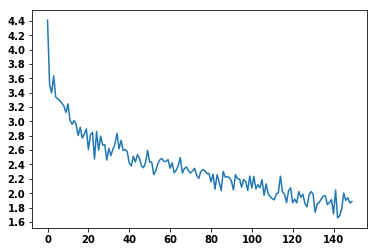

In [18]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words,hidden_size)
attn_decoder1 = AttnDecoderRNN(hidden_size,output_lang.n_words)
trainIters(encoder1,attn_decoder1,15000,print_every=1000)


# 评估

In [36]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]])  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [37]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [38]:
evaluateRandomly(encoder1, attn_decoder1)

> je suis stupefaite .
= i m astonished .
< i m lazy . <EOS>

> tu es la plus vieille .
= you re the oldest .
< you re the teacher . <EOS>

> il compte parmi mes amis .
= he is included among my friends .
< he is my my my . <EOS>

> nous sommes tous sur le meme bateau .
= we re all in the same boat .
< we re all the same same . <EOS>

> je suis incroyablement occupe .
= i m incredibly busy .
< i m busy busy . <EOS>

> vous etes une etudiante .
= you are a student .
< you re a good . <EOS>

> vous etes suffisants .
= you re conceited .
< you re lazy . <EOS>

> c est un lambin .
= he s a slowpoke .
< he is a gentleman . <EOS>

> vous etes trop maigrichons .
= you re too skinny .
< you re too skinny . <EOS>

> je vais te conter un secret .
= i m going to tell you a secret .
< i m going to have a a a a a

